In [1]:
import Path
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.0 MB/s eta 0:00:00
Mounted at /content/gdrive


In [9]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# Utility to download images

In [6]:
from io import BytesIO
import requests
from PIL import Image, UnidentifiedImageError

SEARCH_URL = "https://huggingface.co/api/experimental/images/search"

def get_image_urls_by_term(search_term: str, count=150):
    params  = {"q": search_term, "license": "public", "imageType": "photo", "count": count}
    response = requests.get(SEARCH_URL, params=params)
    response.raise_for_status()
    response_data = response.json()
    image_urls = [img['thumbnailUrl'] for img in response_data['value']]
    return image_urls


def gen_images_from_urls(urls):
    num_skipped = 0
    for url in urls:
        response = requests.get(url)
        if not response.status_code == 200:
            num_skipped += 1
        try:
            img = Image.open(BytesIO(response.content))
            yield img
        except UnidentifiedImageError:
            num_skipped +=1

    print(f"Retrieved {len(urls) - num_skipped} images. Skipped {num_skipped}.")


def urls_to_image_folder(urls, save_directory):
    for i, image in enumerate(gen_images_from_urls(urls)):
        image.save(save_directory / f'{i}.jpg')

# Download images

In [10]:
from pathlib import Path

from pathlib import Path
types = 'drill-driver','hammer-drill','screwgun','electric-screwdriver'
path = Path('images/tools')
path.mkdir(exist_ok=True)
how_many_images=2

for image_type in types:
    dest = path / image_type
    dest.mkdir(exist_ok=True)
    print(f"Downloading {how_many_images} images of '{image_type}'...")
    urls = get_image_urls_by_term(search_term=f"{image_type}", count=how_many_images)
    urls_to_image_folder(urls, dest)


Retrieved 2 images. Skipped 0.
Retrieved 2 images. Skipped 0.
Retrieved 2 images. Skipped 0.
Retrieved 2 images. Skipped 0.


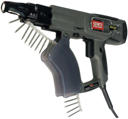

In [6]:
Image.open(f"{path}/electric-screwdriver/electric-screwdriver-0001.jpg").to_thumb(128,128)

In [10]:
fns = get_image_files(path)
fns

(#0) []

In [11]:
failed = verify_images(fns)
failed

(#0) []

In [7]:
failed.map(Path.unlink);

In [13]:
tools = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls = tools.dataloaders(path)

TypeError: 'NoneType' object is not iterable

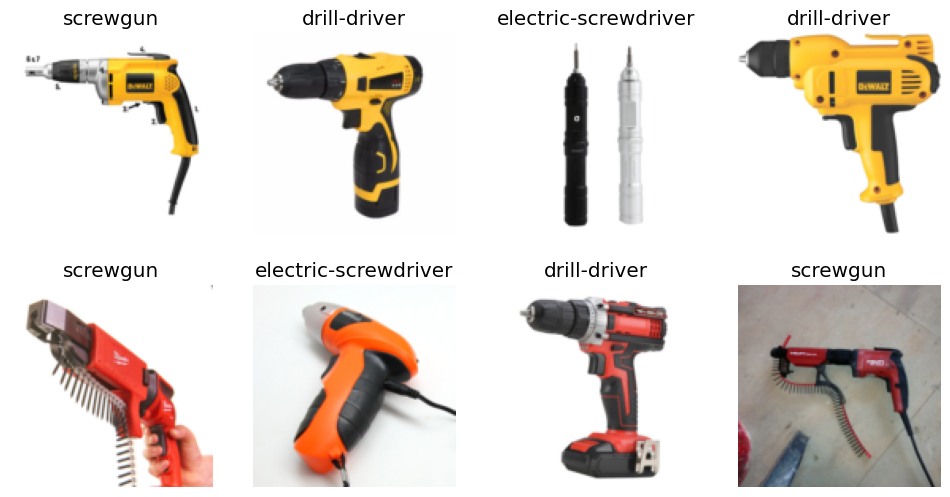

In [10]:
dls.valid.show_batch(max_n=8, nrows=2)

In [11]:
tools = tools.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = tools.dataloaders(path)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.8MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.972616,1.243055,0.450820,00:17


epoch,train_loss,valid_loss,error_rate,time
0,1.253197,0.769188,0.319672,00:17
1,1.058459,0.577668,0.180328,00:15
2,0.894769,0.542168,0.172131,00:17
3,0.783610,0.528302,0.163934,00:23


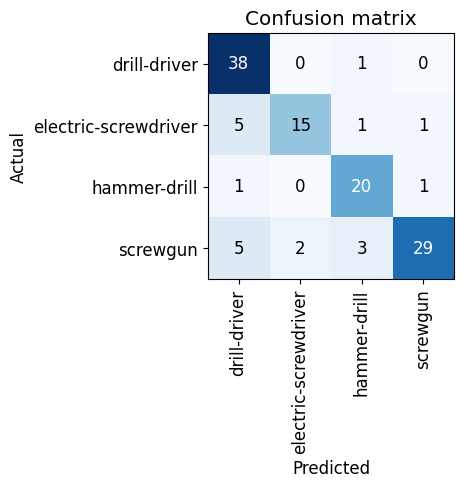

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

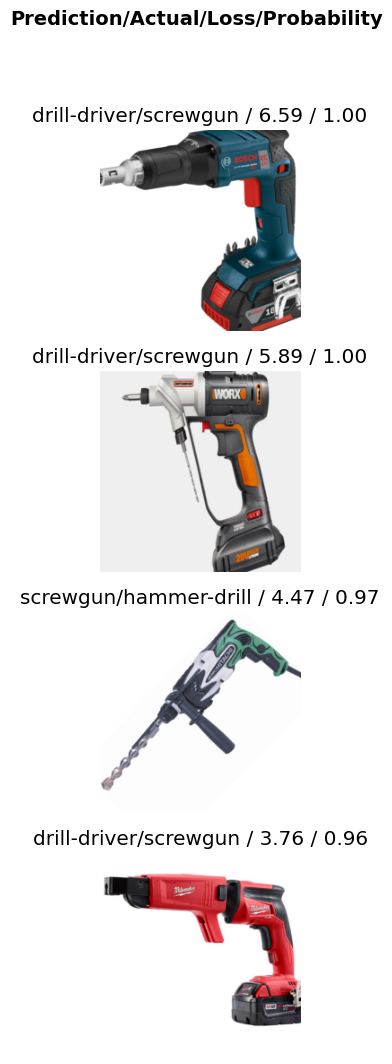

In [14]:
interp.plot_top_losses(4, nrows=4)

In [15]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [16]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Export the model

In [17]:
learn.export(fname=f"{path}/export.pkl")

# Test the exported model

In [18]:
learn_inf = load_learner(path/'export.pkl')

In [19]:
learn_inf.predict(f"{path}/electric-screwdriver/electric-screwdriver-0001.jpg")

('electric-screwdriver',
 tensor(1),
 tensor([1.0820e-03, 9.9801e-01, 3.6219e-05, 8.7429e-04]))

In [20]:
learn_inf.dls.vocab

['drill-driver', 'electric-screwdriver', 'hammer-drill', 'screwgun']